In [1]:
from itertools import chain
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

#fixes some bad rows and seperates data into train and test - note the seperation is not random, it should be.
#dependency collumns are split into rough lists for future
data = read_data()

def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)    
        deps = []
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            deps.append(organized_dependency)
        feature_set.append(deps)
        feature_set.append(sentence)
        dataset.append(feature_set)
        feature_set = []
    return dataset

p_data = pd.DataFrame(process_data(data))


In [2]:
p_data.columns = ['type', 'gerund', 'rel_deps', 'sentence']


In [3]:
def count(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep:
            sum += 1
    return sum

def countGerund(dep, x):
    sum = 0
    for t in x:
        if t[0] == dep and (t[1].endswith('ing') or t[3].endswith('ing')):
            sum += 1
    return sum

def countCC(x):
    return count('cc', x)
def countConj(x):
    return count('conj', x)
def countPunct(x):
    return count('punct', x)

def countGerundCC(x):
    return countGerund('cc', x)
def countGerundConj(x):
    return countGerund('conj', x)
def countGerundPunct(x):
    return countGerund('punct', x)


In [4]:
p_data['num_cc'] = p_data['rel_deps'].apply(countCC)
p_data['num_conj'] = p_data['rel_deps'].apply(countConj)
p_data['num_punct'] = p_data['rel_deps'].apply(countPunct)
p_data['num_gerund_cc'] = p_data['rel_deps'].apply(countGerundCC)
p_data['num_gerund_conj'] = p_data['rel_deps'].apply(countGerundConj)
p_data['num_gerund_punct'] = p_data['rel_deps'].apply(countGerundPunct)


In [5]:
def count_dependencies(rel_deps):
    return len(rel_deps)

def contains_dependency(dep, rel_deps):
    for dependency in rel_deps:
        if dep in dependency:
            return 1
    return 0

def get_unique_deps(rels_deps):
    unique_deps = set()
    for data_point in rels_deps:
        for dep in data_point:
            unique_deps.add(dep[0])
    return list(unique_deps)


p_data['num_deps'] = p_data['rel_deps'].apply(count_dependencies)
dep_types = get_unique_deps(p_data['rel_deps'])
for dep_type in dep_types:
    p_data[f'contains_{dep_type}'] = p_data['rel_deps'].apply(lambda x: contains_dependency(dep_type, x))

p_data2 = p_data[['rel_deps']].copy()
    
for dep_type in dep_types:
    p_data2[f'contains_{dep_type}'] = p_data['rel_deps'].apply(lambda x: contains_dependency(dep_type, x))


In [25]:
p_data['type'].value_counts()

vp-ing         41660
acc-ing         5954
ing-of          2982
det-ing         2959
poss-ing        1249
poss-ing-of      255
Name: type, dtype: int64

## Overall

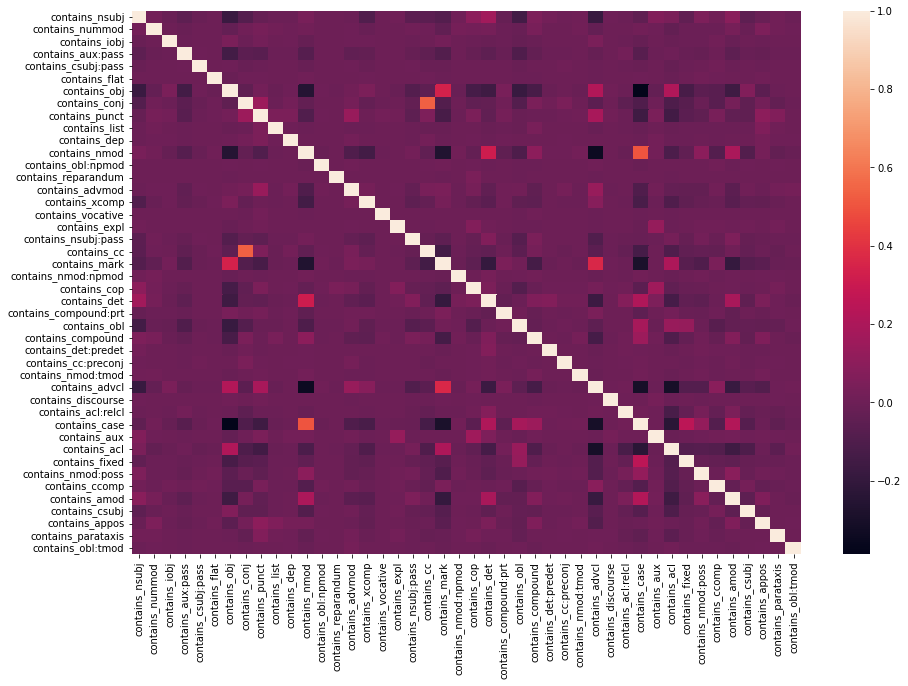

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(p_data2.corr(),  ax=ax)

plt.show()

In [20]:
corr_matrix_overall = p_data2.corr()


In [21]:
top_correlations_pos = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)

top_correlations_neg = corr_matrix_overall.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)

In [22]:
top_positive_correlations

,level_0,level_1,0
1,contains_cc,contains_conj,0.536800
2,contains_nmod,contains_case,0.501393
3,contains_mark,contains_advcl,0.361703
4,contains_mark,contains_obj,0.342636
5,contains_det,contains_nmod,0.313333
6,contains_case,contains_fixed,0.251746
7,contains_advcl,contains_obj,0.224247
8,contains_case,contains_amod,0.220237
9,contains_acl,contains_obj,0.216382
10,contains_case,contains_det,0.208048


In [23]:
top_negative_correlations

,level_0,level_1,0
0,contains_obj,contains_case,-0.388704
1,contains_advcl,contains_nmod,-0.343850
2,contains_acl,contains_advcl,-0.304844
3,contains_case,contains_advcl,-0.304258
4,contains_case,contains_mark,-0.290590
5,contains_mark,contains_nmod,-0.268417
6,contains_obj,contains_nmod,-0.249812
7,contains_case,contains_acl,-0.234133
8,contains_det,contains_mark,-0.190133
9,contains_amod,contains_mark,-0.188222


## Adding type back in

In [26]:
p_data2['type'] = p_data['type']

## vp-ing

In [107]:
vping = p_data2[p_data2['type'] == 'vp-ing']
corr_matrix_vp = vping.corr()
null_columns = corr_matrix_vp.columns[corr_matrix_vp.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)

corr_matrix_vp.drop(null_columns, axis=1, inplace=True)
corr_matrix_vp.dropna(axis=0, how='all', inplace=True)


Columns that are completely null in the correlation matrix: ['contains_det:predet']


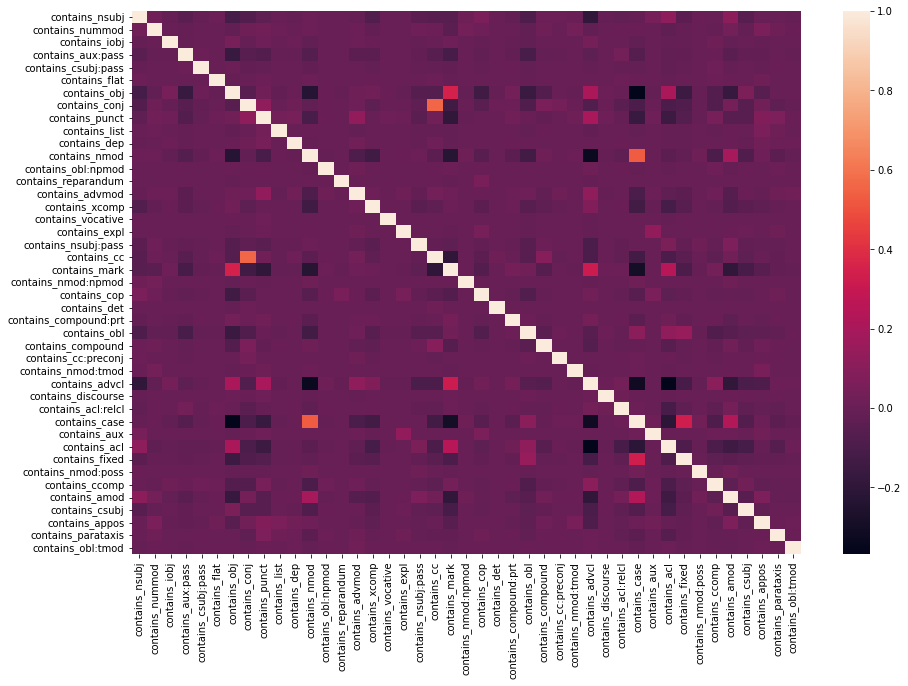

In [108]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_vp,  ax=ax)

plt.show()

In [109]:
top_correlations_pos = corr_matrix_vp.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)


top_correlations_neg = corr_matrix_vp.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)

In [110]:
top_positive_correlations

,level_0,level_1,0
1,contains_cc,contains_conj,0.556833
2,contains_case,contains_nmod,0.533508
3,contains_mark,contains_obj,0.350490
4,contains_case,contains_fixed,0.332744
5,contains_mark,contains_advcl,0.316361
6,contains_acl,contains_mark,0.250561
7,contains_amod,contains_case,0.235406
8,contains_obj,contains_advcl,0.205143
9,contains_acl,contains_obj,0.204644
10,contains_advcl,contains_punct,0.201933


In [111]:
top_negative_correlations

,level_0,level_1,0
0,contains_case,contains_obj,-0.368618
1,contains_acl,contains_advcl,-0.363499
2,contains_nmod,contains_advcl,-0.335120
3,contains_case,contains_advcl,-0.314719
4,contains_mark,contains_case,-0.295683
5,contains_nmod,contains_obj,-0.233984
6,contains_nmod,contains_mark,-0.225761
7,contains_case,contains_acl,-0.213352
8,contains_cc,contains_mark,-0.196478
9,contains_mark,contains_amod,-0.192163


## acc-ing

In [112]:
accing = p_data2[p_data2['type'] == 'acc-ing']
corr_matrix_acc= accing.corr()

null_columns = corr_matrix_acc.columns[corr_matrix_acc.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)

corr_matrix_acc.drop(null_columns, axis=1, inplace=True)
corr_matrix_acc.dropna(axis=0, how='all', inplace=True)


Columns that are completely null in the correlation matrix: ['contains_reparandum', 'contains_det', 'contains_det:predet', 'contains_nmod:poss']


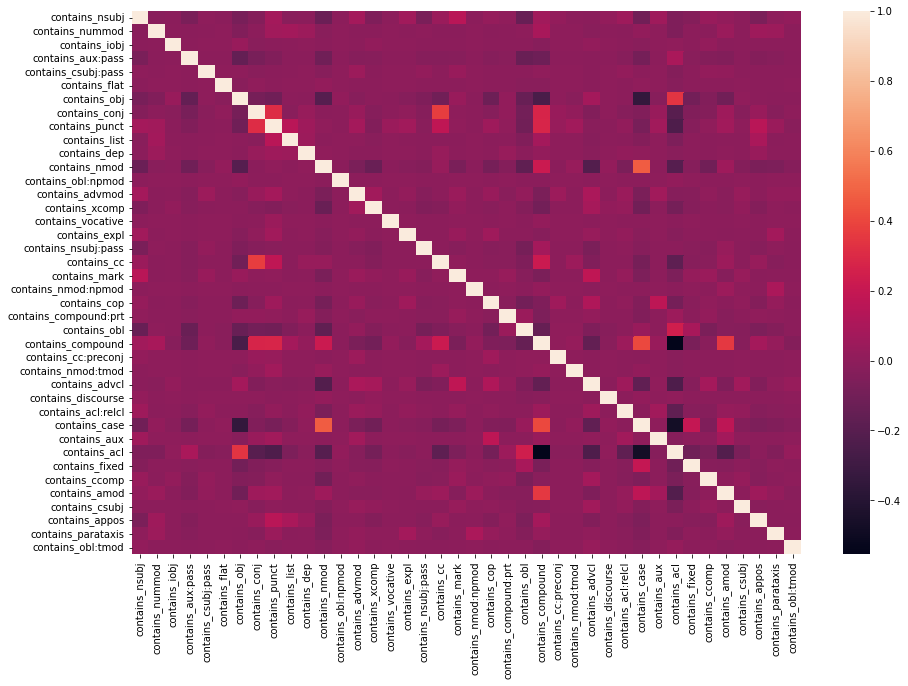

In [113]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_acc,  ax=ax)

plt.show()

In [114]:
top_correlations_pos = corr_matrix_vp.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)


top_correlations_neg = corr_matrix_vp.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)

In [115]:
top_positive_correlations

,level_0,level_1,0
1,contains_cc,contains_conj,0.556833
2,contains_case,contains_nmod,0.533508
3,contains_mark,contains_obj,0.350490
4,contains_case,contains_fixed,0.332744
5,contains_mark,contains_advcl,0.316361
6,contains_acl,contains_mark,0.250561
7,contains_amod,contains_case,0.235406
8,contains_obj,contains_advcl,0.205143
9,contains_acl,contains_obj,0.204644
10,contains_advcl,contains_punct,0.201933


In [116]:
top_negative_correlations

,level_0,level_1,0
0,contains_case,contains_obj,-0.368618
1,contains_acl,contains_advcl,-0.363499
2,contains_nmod,contains_advcl,-0.335120
3,contains_case,contains_advcl,-0.314719
4,contains_mark,contains_case,-0.295683
5,contains_nmod,contains_obj,-0.233984
6,contains_nmod,contains_mark,-0.225761
7,contains_case,contains_acl,-0.213352
8,contains_cc,contains_mark,-0.196478
9,contains_mark,contains_amod,-0.192163


## ing-of

In [117]:
ingof = p_data2[p_data2['type'] == 'ing-of']
corr_matrix_ing = ingof.corr()

null_columns = corr_matrix_ing.columns[corr_matrix_ing.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)

corr_matrix_ing.drop(null_columns, axis=1, inplace=True)
corr_matrix_ing.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_iobj', 'contains_aux:pass', 'contains_flat', 'contains_list', 'contains_nmod', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_compound:prt', 'contains_fixed', 'contains_nmod:poss', 'contains_obl:tmod']


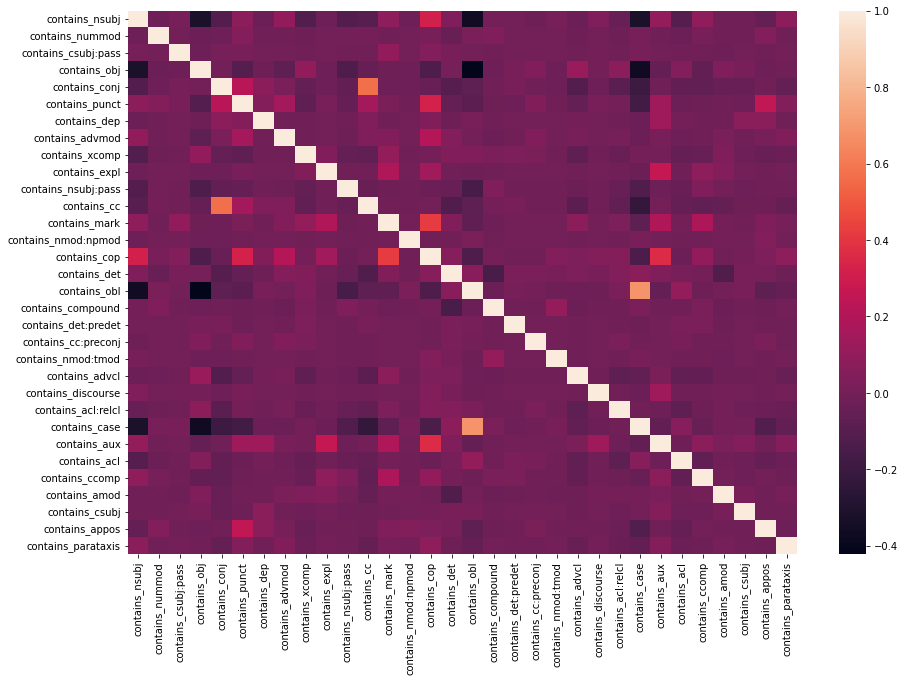

In [118]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_ing,  ax=ax)

plt.show()

In [119]:
top_correlations_pos = corr_matrix_ing.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)

top_correlations_neg = corr_matrix_ing.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)

In [120]:
top_positive_correlations

,level_0,level_1,0
1,contains_case,contains_obl,0.686145
2,contains_conj,contains_cc,0.571995
3,contains_mark,contains_cop,0.418950
4,contains_cop,contains_aux,0.365006
5,contains_punct,contains_cop,0.325024
6,contains_cop,contains_nsubj,0.320159
7,contains_expl,contains_aux,0.270655
8,contains_appos,contains_punct,0.253930
9,contains_punct,contains_conj,0.224185
10,contains_advmod,contains_cop,0.206940


In [121]:
top_negative_correlations

,level_0,level_1,0
0,contains_obj,contains_obl,-0.421824
1,contains_case,contains_obj,-0.362250
2,contains_nsubj,contains_obl,-0.357713
3,contains_obj,contains_nsubj,-0.318937
4,contains_case,contains_nsubj,-0.318769
5,contains_case,contains_cc,-0.229443
6,contains_conj,contains_case,-0.189880
7,contains_punct,contains_case,-0.169910
8,contains_obl,contains_nsubj:pass,-0.152933
9,contains_det,contains_compound,-0.148040


## det-ing

In [122]:
deting = p_data2[p_data2['type'] == 'det-ing']
corr_matrix_det = deting.corr()

null_columns = corr_matrix_det.columns[corr_matrix_det.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)


corr_matrix_det.drop(null_columns, axis=1, inplace=True)
corr_matrix_det.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_aux:pass', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_det', 'contains_discourse']


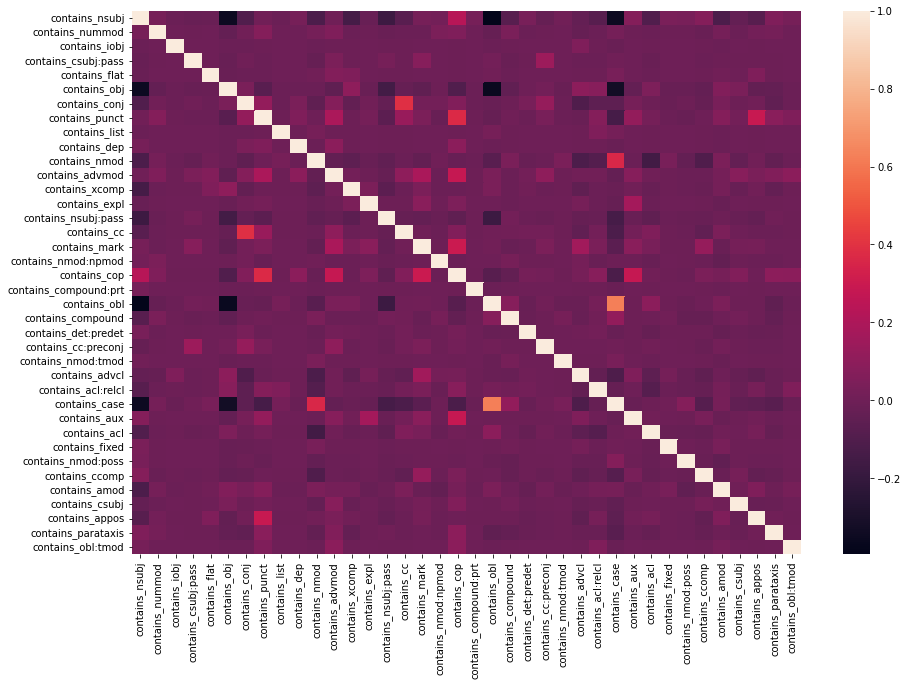

In [123]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_det,  ax=ax)

plt.show()

In [124]:
top_correlations_pos = corr_matrix_det.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)


top_correlations_neg = corr_matrix_det.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)


In [125]:
top_positive_correlations

,level_0,level_1,0
1,contains_obl,contains_case,0.628491
2,contains_conj,contains_cc,0.394200
3,contains_cop,contains_punct,0.372314
4,contains_case,contains_nmod,0.360835
5,contains_cop,contains_mark,0.301842
6,contains_appos,contains_punct,0.286061
7,contains_cop,contains_aux,0.281520
8,contains_cop,contains_advmod,0.280840
9,contains_nsubj,contains_cop,0.232230
10,contains_advmod,contains_punct,0.195143


In [126]:
top_negative_correlations

,level_0,level_1,0
0,contains_nsubj,contains_obl,-0.395921
1,contains_obl,contains_obj,-0.358549
2,contains_obj,contains_nsubj,-0.349646
3,contains_case,contains_nsubj,-0.347701
4,contains_case,contains_obj,-0.327609
5,contains_nsubj:pass,contains_obl,-0.173116
6,contains_nsubj,contains_nsubj:pass,-0.168142
7,contains_acl,contains_nmod,-0.155530
8,contains_nsubj:pass,contains_obj,-0.146363
9,contains_xcomp,contains_nsubj,-0.142646


## poss-ing

In [127]:
possing = p_data2[p_data2['type'] == 'poss-ing']
corr_matrix_possing = possing.corr()

null_columns = corr_matrix_possing.columns[corr_matrix_possing.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)


corr_matrix_possing.drop(null_columns, axis=1, inplace=True)
corr_matrix_possing.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_iobj', 'contains_aux:pass', 'contains_list', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_compound:prt', 'contains_discourse', 'contains_fixed', 'contains_nmod:poss']


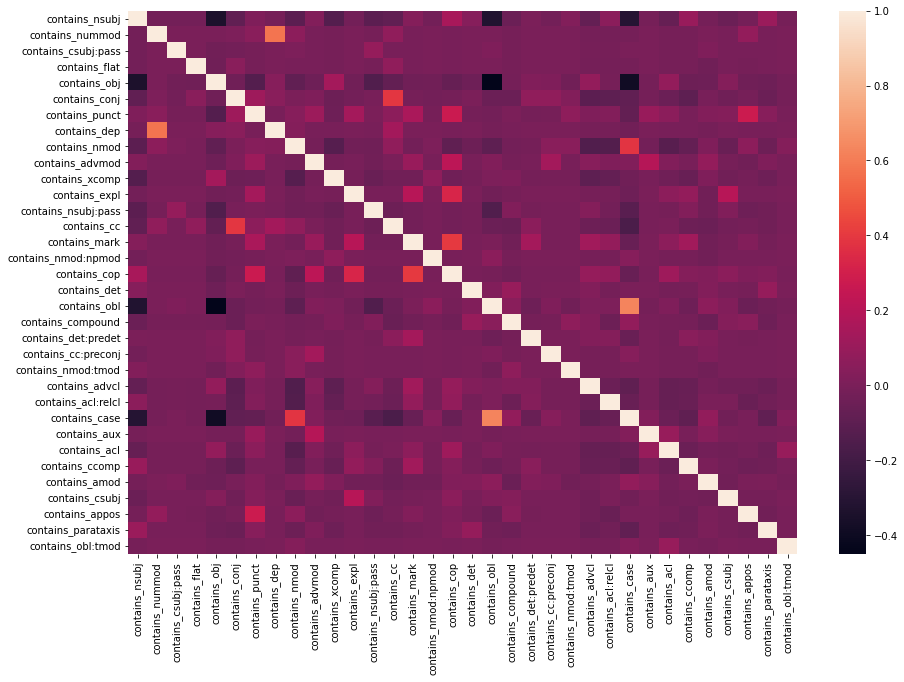

In [128]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_possing,  ax=ax)

plt.show()

In [129]:
top_correlations_pos = corr_matrix_possing.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)


top_correlations_neg = corr_matrix_possing.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)


In [130]:
top_positive_correlations

,level_0,level_1,0
1,contains_case,contains_obl,0.626558
2,contains_dep,contains_nummod,0.576887
3,contains_mark,contains_cop,0.401302
4,contains_cc,contains_conj,0.390712
5,contains_nmod,contains_case,0.386257
6,contains_expl,contains_cop,0.331188
7,contains_appos,contains_punct,0.274886
8,contains_punct,contains_cop,0.274517
9,contains_cop,contains_advmod,0.222550
10,contains_expl,contains_csubj,0.201332


In [131]:
top_negative_correlations

,level_0,level_1,0
0,contains_obl,contains_obj,-0.450685
1,contains_obj,contains_case,-0.388035
2,contains_nsubj,contains_obj,-0.340079
3,contains_obl,contains_nsubj,-0.325067
4,contains_case,contains_nsubj,-0.306513
5,contains_case,contains_cc,-0.165287
6,contains_obj,contains_nsubj:pass,-0.143711
7,contains_advcl,contains_nmod,-0.142641
8,contains_nsubj:pass,contains_obl,-0.141102
9,contains_acl:relcl,contains_nmod,-0.134124


## poss-ing-of

In [132]:
possingof = p_data2[p_data2['type'] == 'poss-ing-of']
corr_matrix_possof = possingof.corr()

null_columns = corr_matrix_possof.columns[corr_matrix_possof.isnull().all()].tolist()
print("Columns that are completely null in the correlation matrix:", null_columns)


corr_matrix_possof.drop(null_columns, axis=1, inplace=True)
corr_matrix_possof.dropna(axis=0, how='all', inplace=True)

Columns that are completely null in the correlation matrix: ['contains_iobj', 'contains_aux:pass', 'contains_csubj:pass', 'contains_flat', 'contains_list', 'contains_nmod', 'contains_obl:npmod', 'contains_reparandum', 'contains_vocative', 'contains_expl', 'contains_nmod:npmod', 'contains_compound:prt', 'contains_det:predet', 'contains_nmod:tmod', 'contains_discourse', 'contains_fixed', 'contains_nmod:poss', 'contains_obl:tmod']


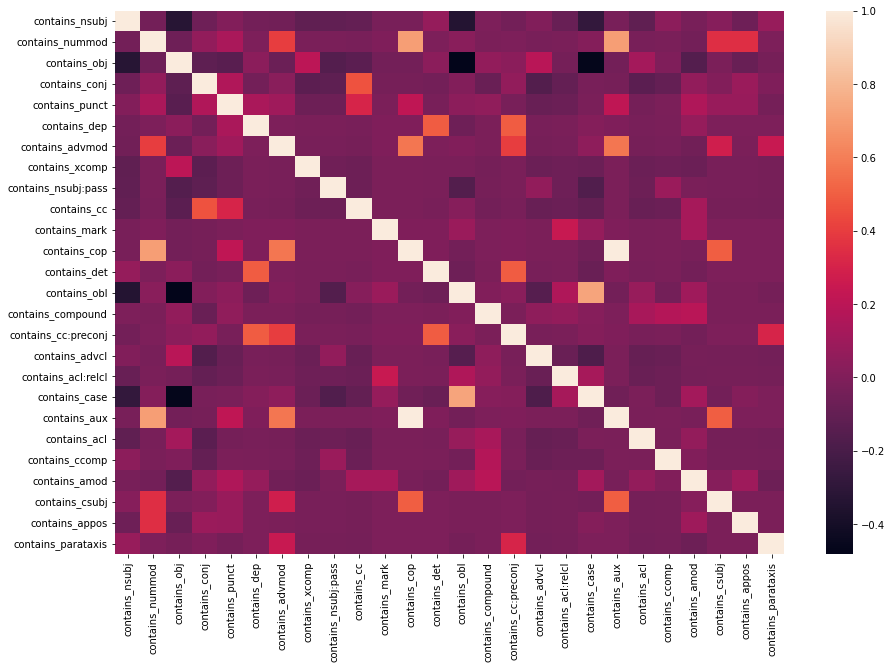

In [133]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(corr_matrix_possof,  ax=ax)

plt.show()

In [134]:
top_correlations_pos = corr_matrix_possof.unstack().sort_values(ascending=False).drop_duplicates().reset_index()
top_correlations_pos = top_correlations_pos[top_correlations_pos['level_0'] != top_correlations_pos['level_1']]
top_positive_correlations = top_correlations_pos[top_correlations_pos[0] > 0].head(10)


top_correlations_neg = corr_matrix_possof.unstack().sort_values().drop_duplicates().reset_index()
top_correlations_neg = top_correlations_neg[top_correlations_neg['level_0'] != top_correlations_neg['level_1']]
top_negative_correlations = top_correlations_neg[top_correlations_neg[0] < 0].head(10)


In [135]:
top_positive_correlations

,level_0,level_1,0
1,contains_case,contains_obl,0.731946
2,contains_nummod,contains_aux,0.705713
3,contains_aux,contains_advmod,0.575073
4,contains_aux,contains_csubj,0.497038
5,contains_dep,contains_det,0.496047
6,contains_det,contains_cc:preconj,0.496047
7,contains_cc:preconj,contains_dep,0.496047
8,contains_conj,contains_cc,0.462730
9,contains_cc:preconj,contains_advmod,0.402590
10,contains_nummod,contains_advmod,0.402590


In [136]:
top_negative_correlations

,level_0,level_1,0
0,contains_obl,contains_obj,-0.482451
1,contains_case,contains_obj,-0.468042
2,contains_obl,contains_nsubj,-0.340503
3,contains_obj,contains_nsubj,-0.328551
4,contains_nsubj,contains_case,-0.284664
5,contains_case,contains_advcl,-0.178888
6,contains_nsubj:pass,contains_case,-0.169195
7,contains_obl,contains_nsubj:pass,-0.163889
8,contains_advcl,contains_conj,-0.158917
9,contains_nsubj:pass,contains_obj,-0.158136


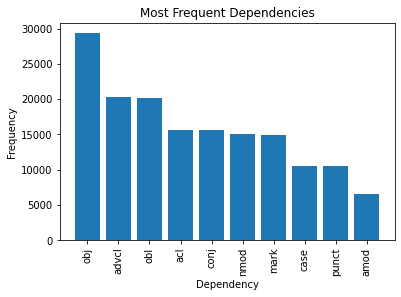

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

all_deps = []
for rels_deps in p_data['rel_deps']:
    for dep in rels_deps:
        all_deps.append(dep[0])

dep_counts = Counter(all_deps)

most_common_deps = dep_counts.most_common(10)

# Create a bar chart of the most frequent dependencies
labels, values = zip(*most_common_deps)
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.xlabel('Dependency')
plt.ylabel('Frequency')
plt.title('Most Frequent Dependencies')
plt.show()
